In [1]:
import pandas as pd
from tqdm import tqdm
import torch
import numpy as np
from matplotlib import pyplot as plt
import json


def batchify(l, batch_size):
    i = 0
    while i < len(l):
        i += batch_size
        yield l[i-batch_size:i]


test_data = pd.read_csv("Bert_Model/new_17resid_test_data.txt", encoding='unicode_escape', names=['Seq'])
test_target = pd.read_csv("Bert_Model/Ntest_3states_target.txt", encoding='unicode_escape', names=['target'])


from transformers import AutoTokenizer, T5ForConditionalGeneration
model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = AutoTokenizer.from_pretrained("t5-small")


df_ = pd.concat([test_data, test_target], axis=1).head(1000)
df_["x"] = df_.Seq.apply(lambda val: " ".join([x.replace("B", tokenizer.pad_token) for x in val]))
df_

/media/HDD/bportelli/env/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


,Seq,target,x
0,BBBBBBBBAAADGDDSL,1,<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad...
1,BBBBBBBAAADGDDSLY,1,<pad> <pad> <pad> <pad> <pad> <pad> <pad> A A ...
2,BBBBBBAAADGDDSLYP,1,<pad> <pad> <pad> <pad> <pad> <pad> A A A D G ...
3,BBBBBAAADGDDSLYPI,1,<pad> <pad> <pad> <pad> <pad> A A A D G D D S ...
4,BBBBAAADGDDSLYPIA,1,<pad> <pad> <pad> <pad> A A A D G D D S L Y P I A
...,...,...,...
995,GLTRPKYSLTLTDYDGS,2,G L T R P K Y S L T L T D Y D G S
996,LTRPKYSLTLTDYDGSN,2,L T R P K Y S L T L T D Y D G S N
997,TRPKYSLTLTDYDGSNN,2,T R P K Y S L T L T D Y D G S N N
998,RPKYSLTLTDYDGSNNF,2,R P K Y S L T L T D Y D G S N N F


In [2]:
# tokenizer.bos_token = tokenizer.eos_token
# tokenizer.bos_token_id

In [21]:
import torch.nn as nn
from captum.attr import DeepLift

device = "cuda"


class BertModelWrapper(nn.Module):

    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model

    def forward(self, embeddings, attention_mask=None, head_mask=None, position=0):
        model_class = type(self.model)
        outputs = self.model.generate(
            inputs_embeds = embeddings,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=1,
            # attention_mask = attention_mask, 
            # head_mask = head_mask,
        )
        outputs = outputs.scores
      
        return outputs[0]  # .argmax(1)

def interpret_sentence(model_wrapper, sentence, label=1, position=0, plot=True, max_len=None):
    model_wrapper.eval()
    model_wrapper.zero_grad()
    max_len = model_wrapper.model.config.max_position_embeddings if max_len is None else max_len

    tok_out = tokenizer(sentence, add_special_tokens=False, padding="longest")#"max_length", max_length=max_len)
    
    tok_out = [
        [x for x in seq if (x != 3) and (x != 0)]
        for seq in tok_out.input_ids
    ]
    tok_out = [
        seq + [tokenizer.pad_token_id]*(max_len-len(seq))
        for seq in tok_out
    ]
    
    for x,s in zip(tok_out, sentence):
        if len(x)!=17:
            print(len(x), x, s)
    
    input_ids = torch.tensor(tok_out)
    baseline_input_ids = torch.ones_like(input_ids) * tokenizer.pad_token_id

    attention_mask = torch.ones_like(input_ids)
    
    input_ids=input_ids.to(device)
    baseline_input_ids=baseline_input_ids.to(device)
    
    input_embedding = model_wrapper.model.shared(input_ids)
    baseline_input_embedding = model_wrapper.model.shared(baseline_input_ids)

    # predict
    pred = model_wrapper(input_embedding)  # .item()
    
    # print(pred)
    
    
    # print(input_embedding)
    # print(baseline_input_embedding)
    
    
    # print(model_wrapper(baseline_input_embedding))
    
    # pred_ind = pred.argmax().item()  # round(pred)
    
    # compute attributions and approximation delta using integrated gradients
    # if CAPTUM_ALG == IntegratedGradients:
    #     attributions_ig, delta = ig.attribute(input_embedding, n_steps=2, target=label)
    # elif CAPTUM_ALG == Saliency or CAPTUM_ALG == FeatureAblation or CAPTUM_ALG == DeepLift:
    #     attributions_ig = ig.attribute(
    #         input_embedding,
    #         target=label,
    #         baselines=baseline_input_embedding,
    #         additional_forward_args=(None, None, position)
    #     )
    attributions_ig = dl.attribute(
            input_embedding,
            target=label,
            baselines=baseline_input_embedding,
            additional_forward_args=(None, None, position)
    )

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu().numpy().tolist())

    attributions = attributions_ig.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions, dim=-1).unsqueeze(-1)
    if len(attributions.shape) == 1:
        attributions = attributions.unsqueeze(0)
    attributions = attributions.detach().cpu().numpy()
    # attributions = np.mean(attributions, axis=0)
    attributions = np.mean(np.absolute(attributions), axis=0)

    if plot:
        visualize_importances(tokens, attributions, log=False)
    # return tokens, attributions, pred, pred_ind, label
    return attributions

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True,
                          axis_title="Features", log=False):
    print(title)
    x_pos = [x for x in range(len(feature_names))]
    if plot:
        # plt.figure(figsize=(6, 4))
        plt.plot(x_pos, importances)
        # plt.bar(x_pos, importances, align='center')
        #         plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        if log:
            plt.yscale('log')
        plt.title(title)
        plt.tight_layout()
        # plt.show()

In [22]:
bert_model_wrapper = BertModelWrapper(model)
dl = DeepLift(bert_model_wrapper)
_ = bert_model_wrapper.to(device)

In [23]:
sent_0 = df_.x[df_.target==0].tolist()
attrib_0 = []
for sent_batch in tqdm(batchify(sent_0, 100), total=len(sent_0)//100):
    attrib = interpret_sentence(
        bert_model_wrapper,
        sentence=sent_batch,
        label=1,
        max_len=17,
        position=8,
        plot=False
    )
    attrib_0.append(attrib[:17])
sent_1 = df_.x[df_.target==1].tolist()
attrib_1 = []
for sent_batch in tqdm(batchify(sent_1, 100), total=len(sent_1)//100):
    attrib = interpret_sentence(
        bert_model_wrapper,
        sentence=sent_batch,
        label=1,
        max_len=17,
        position=8,
        plot=False
    )
    attrib_1.append(attrib[:17])
    
sent_2 = df_.x[df_.target==2].tolist()
attrib_2 = []
for sent_batch in tqdm(batchify(sent_2, 100), total=len(sent_2)//100):
    attrib = interpret_sentence(
        bert_model_wrapper,
        sentence=sent_batch,
        label=2,
        max_len=17,
        position=8,
        plot=False
    )
    attrib_2.append(attrib[:17])

6it [00:00,  8.56it/s]                                                                                                  
3it [00:00,  9.84it/s]                                                                                                  
2it [00:00, 11.95it/s]                                                                                                  


In [24]:
avg_0 = np.mean(attrib_0, axis=0)
avg_1 = np.mean(attrib_1, axis=0)
avg_2 = np.mean(attrib_2, axis=0)

In [25]:
avg_0

array([0.21275407, 0.18024166, 0.18390311, 0.18745466, 0.18280984,
       0.17774367, 0.1760658 , 0.1756329 , 0.17240149, 0.17264968,
       0.1655397 , 0.16987173, 0.17530452, 0.1841032 , 0.20267248,
       0.2090099 , 0.24785304], dtype=float32)

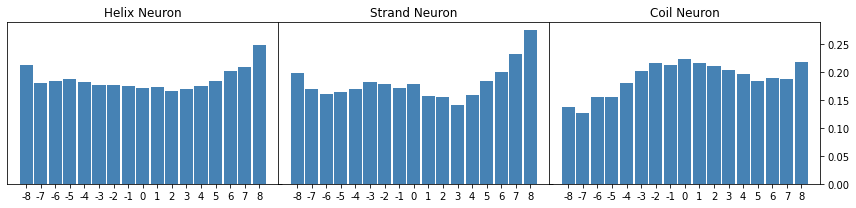

In [26]:
LABELS = ["-"+str(x) for x in range(8,0,-1)]+[str(0)]+[str(x) for x in range(1,9,1)]

def get_sign_color(w0, pos="steelblue", neg="black"):
    return [neg if x<0 else pos for x in w0]


abs_avg_w0 = abs(avg_0)
abs_avg_w1 = abs(avg_1)
abs_avg_w2 = abs(avg_2)

fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
for i,ax in enumerate(axs):
    ax.yaxis.tick_right()
    ax.set_xticks(range(len(abs_avg_w0)))
    ax.set_xticklabels(LABELS)
    if i == 2:
        ax.yaxis.set_tick_params(labelright=True, labelleft=False)
    else:
        for label in ax.get_yticklabels():
            label.set_visible(False)
axs[0].bar(range(17), abs_avg_w0, color=get_sign_color(avg_0), width=.9)
axs[1].bar(range(17), abs_avg_w1, color=get_sign_color(avg_1), width=.9)
axs[2].bar(range(17), abs_avg_w2, color=get_sign_color(avg_2), width=.9)
axs[0].set_title(f"Helix Neuron")
axs[1].set_title(f"Strand Neuron")
axs[2].set_title(f"Coil Neuron")

plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0)
# plt.savefig(f"BERT_Model.deeplift.avg.pdf", dpi=300)
plt.show()